In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cvxpy as cp
import scipy
from sklearn.linear_model import LassoLars
from SparseOpt.helper import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
m = 15
D = 1 * np.diag(1*np.random.rand(m)) # np.eye(m)
print(np.max(D)/np.min(np.diag(D)))
Dhalf = np.sqrt(D)
rank = 5
L = 5 * np.random.randn(m,rank)
X = scipy.linalg.sqrtm(D + L @ L.T)
y = 10*np.random.randn(m) - 3
p = X.T @ y

11.850668684604505


In [7]:
if m <= 15:
    l0_costs, l0_supp = [], []
    l0_sols = []
    M_list = []
    for k in range(1,m+1):
        supp, cost = l0_bruteforce(D + L @ L.T + 1 * np.eye(m), p, k)
        l0_costs.append(cost)
        l0_supp.append(np.where(np.array(supp) == 1)[0])
        
        #solution
        idx = np.where(np.array(supp) == 1)[0]
        Xtilde = X[:, idx]
        sol = np.linalg.inv(Xtilde.T @ Xtilde) @ Xtilde.T @ y
        l0_sols.append(sol)
        M_list.append(np.max(np.abs(sol)))

NameError: name 'l0_bruteforce' is not defined

In [26]:
print(l0_sols[3])
print(l0_supp[3])
print(l0_costs[3])

[-1.75561916  0.4361077   3.70747508 -6.95287895]
[0 1 4 6]
-189.73831412319964


In [27]:
x = np.ones(m)
f_costs= []
for k in range(1, m+1):
    costs = []

    for i in range(20):

        #minimize u
        u = cp.Variable(m)
        cost = 0
        for j in range(m):
            cost += cp.quad_over_lin(x[j], u[j])
        constr = [u <= 1, cp.sum(u) <= k]

        prob = cp.Problem(cp.Minimize(cost), constr)
        prob.solve()
        Du = np.diag(u.value)

        costs.append(1/2 * np.linalg.norm(X @ x - y) ** 2 + 1/2 * x.T @ np.linalg.inv(Du) @ x - 1/2 * y.T @ y)

        #minimize x
        x = np.linalg.inv(X.T @ X + 1 * np.linalg.inv(Du)) @ X.T @ y
    
    f_costs.append(costs[-1])
    print(sum(u.value))
    
    

print(x)
print(u.value)
print(1/2 * np.linalg.norm(X @ x - y) ** 2 + 1/2 * x.T @ np.linalg.inv(Du) @ x - 1/2 * y.T @ y)

1.0000000725663898
2.000000211655431
3.0000000010838757
4.000000003324583
5.000000008932123
6.000000000532822
6.999999904163125
7.999999837402473
8.999999790124718
9.999995212560806
[-0.16150198 -0.98076845  2.88573359  2.68107097  2.33671807 -1.38622215
 -5.00251931 -0.13685122 -2.02600958 -0.9411167 ]
[0.99999952 0.99999996 1.         1.         1.         0.99999999
 1.00000001 0.99999577 1.         0.99999996]
-211.45434227243172


In [28]:
print(sum(u.value))

9.999995212560806


In [29]:
print(l0_costs)
print(f_costs)

[-126.3464205671601, -153.34669903231887, -183.7465924649307, -189.73831412319964, -197.3786910276514, -202.9775314743337, -207.6716657989649, -211.31440556006777, -211.42761026255474, -211.45434228670288]
[-171.48824396476195, -185.95773410339996, -194.60391834358566, -199.8228183033149, -204.67196251931315, -208.13177021628087, -210.37801373222294, -211.32084525098057, -211.4366424854733, -211.45434227243172]


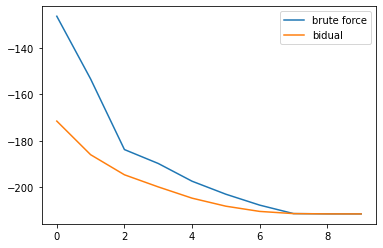

In [30]:
plt.figure()
plt.plot(l0_costs)
plt.plot(f_costs)
plt.legend(['brute force', 'bidual'])
plt.show()

In [10]:
u.value

array([0.08629999, 0.17943918, 0.42351284, 1.00000019, 0.10198676,
       0.07748528, 1.00000004, 0.00343833, 0.12783697, 1.00000026])

In [31]:
# more interesting to see how lasso compares in terms of solution quality and in terms of empirical performance on ML tasks